## Early aims for this Notebook:
- Make a function that lets you easily load CSVs from URLs to variables
- Function that flexibly cleans DataFrames, as different locations have different air pollution metrics

In [101]:
%%time
### Imports ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-poster')
from matplotlib.pyplot import *
from datetime import timedelta
import calendar # for getting month name i.e. Feb from month number
from urllib.request import urlretrieve # for getting data from URLs
from datetime import datetime
import datetime as dt
import os # for deleting files
%matplotlib inline

Wall time: 973 µs


---

To start with, will compare **Reading London Road** ([link](https://uk-air.defra.gov.uk/data/flat_files?site_id=REA5)) to **Derby** ([link](https://uk-air.defra.gov.uk/data/flat_files?site_id=DESA)) to **Newcastle Centre** ([link](https://uk-air.defra.gov.uk/data/flat_files?site_id=NEWC))

---

### Data for each location:
#### Derby:
- Data from: 2017
- Metrics: Nitric oxide, Nitrogen dioxide, Nitrogen oxides as nitrogen dioxide

#### Reading: 
- Data from: 
- Metrics: Nitric oxide, Nitrogen dioxide, Nitrogen oxides as nitrogen dioxide, PM10 particulate matter

#### Newcastle: 
- Data from: 1992
- Metrics: Ozone

#### Total metrics that can be measured:
- Ozone, Nitric oxide, Nitrogen dioxide, Nitrogen oxides as nitrogen dioxide, Sulphur dioxide, Carbon monoxide, PM10 particulate matter, Non-volatile PM10, Colatile PM10, PM 2.5 particulate matter, Non-volatile PM2.5, Volatile PM2.5

---

### Get data & clean it

In [117]:
%%time
def getdata(*urls):
	for i in urls:
   		yield pd.read_csv(i,skiprows=4)

        
derby20, derby19, derby18, derby17 = getdata('https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv',
                                             'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv',
                                             'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv',
                                             'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv')

reading20, reading19, reading18,reading17, reading16 = getdata('https://uk-air.defra.gov.uk/data_files/site_data/REA5_2020.csv',
                                                               'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2019.csv',
                                                               'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2018.csv',
                                                               'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2017.csv',
                                                               'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2016.csv')

newcastle20, newcastle19, newcastle18, newcastle17, newcastle16 = getdata('https://uk-air.defra.gov.uk/data_files/site_data/NEWC_2020.csv',
                                                                         'https://uk-air.defra.gov.uk/data_files/site_data/NEWC_2019.csv',
                                                                         'https://uk-air.defra.gov.uk/data_files/site_data/NEWC_2018.csv',
                                                                         'https://uk-air.defra.gov.uk/data_files/site_data/NEWC_2017.csv',
                                                                         'https://uk-air.defra.gov.uk/data_files/site_data/NEWC_2016.csv')


Wall time: 5.01 s


In [118]:
def cleaner(df):
    '''Takes Pandas DataFrame and sets Date to DateTime, 
    replaces date x : 24:00 hours to data x +1 00:00 hours,
    creates new columns i.e. day of the week, month, quarter,
    drops unneccesary columns i.e. unit.9, unit.8, status.9, status.8 etc'''
    # Changing date from object to datetime
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d-%m-%Y') # makes sure string is in correct format
    df['Date'] = pd.to_datetime(df['Date']) # converts to datetime
    
    # Loop to add 1 to date for every 24th entry, as they are stored as date x & 24:00 when they need to be date x + 1 & 00:00
    # Potentially a very inefficient way to do it
    counter = 0
    for i, row in df.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = df.at[i,'Date'] + pd.Timedelta(1,unit='d')
            df.at[i,'Date'] = value
    
    # Replacing 24:00 with 00:00
    df['time'] = df['time'].replace(to_replace='24:00',value='00:00') 
    
    # Combining date and time columns
    df['Date String'] = df['Date'].astype(str)
    df['Date Time String'] = df['Date String'] + " " + df['time']
    df['Date Time'] = pd.to_datetime(df['Date Time String'])
    
    # Feature Engineering
    df['Week'] = df['Date Time'].dt.week
    df['Day Of Week'] = df['Date Time'].dt.dayofweek
    df['Quarter'] = df['Date Time'].dt.quarter
    df['Month'] = df['Date Time'].dt.month
    df['Weekday Or Weekend'] = np.where(df['Day Of Week'] >=5,'Weekend','Weekday')
    df['NO + NO2'] = df['Nitric oxide'] + df['Nitrogen dioxide']
    
    # Setting index to be Date Time
    df.index = df['Date Time']
    
    # dropping columns if they exist
    to_drop = ['unit.10','unit.9','unit.8','unit.7','unit.6','unit.5','unit.4','unit.3','unit.2','unit.1','unit',
              'status.10','status.9','status.8','status.7','status.6','status.5','status.4','status.3','status.2','status.1','status',
              'Date','time','Date String','Date Time String']
    for i in to_drop:
        try:
            df.drop(i,axis=1,inplace=True)
        except:
            continue

In [119]:
for df in (derby20,derby19,derby18,derby17,
           newcastle20,newcastle19,newcastle18,newcastle17,newcastle16,
          reading20,reading19,reading18,reading17,reading16):
    cleaner(df)

In [140]:
derby = pd.concat([derby20,derby19,derby18,derby17],sort=False) # had to add sort=False to silence an error that I should really investigate

reading = pd.concat([reading20,reading19,reading18,reading17,reading16],sort=False)

newcastle = pd.concat([newcastle20,newcastle19,newcastle18,newcastle17,newcastle16],sort=False)


In [137]:
newcastle

,PM<sub>10</sub> particulate matter (Hourly measured),Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Non-volatile PM<sub>10</sub> (Hourly measured),Non-volatile PM<sub>2.5</sub> (Hourly measured),Ozone,PM<sub>2.5</sub> particulate matter (Hourly measured),Volatile PM<sub>10</sub> (Hourly measured),Volatile PM<sub>2.5</sub> (Hourly measured),Date Time,Week,Day Of Week,Quarter,Month,Weekday Or Weekend,Newcastle NO + NO2
Date Time,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,14.2,1.35889,20.25424,22.33784,6.8,3.6,56.21222,8.2,7.4,4.6,2020-01-01 01:00:00,1,2,1,1,Weekday,21.61313
2020-01-01 02:00:00,10.3,1.35889,21.90211,23.98571,7.5,5.8,54.88175,7.7,2.8,1.9,2020-01-01 02:00:00,1,2,1,1,Weekday,23.26100
2020-01-01 03:00:00,14.5,20.14357,49.44746,80.33383,9.0,9.3,18.70969,14.0,5.5,4.7,2020-01-01 03:00:00,1,2,1,1,Weekday,69.59103
2020-01-01 04:00:00,19.6,70.92214,69.17880,177.92456,19.3,14.5,1.14753,17.0,0.3,2.5,2020-01-01 04:00:00,1,2,1,1,Weekday,140.10094
2020-01-01 05:00:00,25.8,77.45681,58.01475,176.78020,17.5,18.7,0.99785,22.4,8.3,3.7,2020-01-01 05:00:00,1,2,1,1,Weekday,135.47156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,8.8,2.93864,25.49028,29.99613,7.6,6.6,45.55185,9.2,1.2,2.6,2016-12-31 20:00:00,52,5,4,12,Weekend,28.42892
2016-12-31 21:00:00,8.0,2.90777,25.20340,29.66192,4.8,3.0,43.30669,5.2,3.2,2.2,2016-12-31 21:00:00,52,5,4,12,Weekend,28.11117
2016-12-31 22:00:00,5.0,2.87659,31.07860,35.48931,3.7,5.4,36.57120,8.7,1.3,3.3,2016-12-31 22:00:00,52,5,4,12,Weekend,33.95519


# Some quick EDA

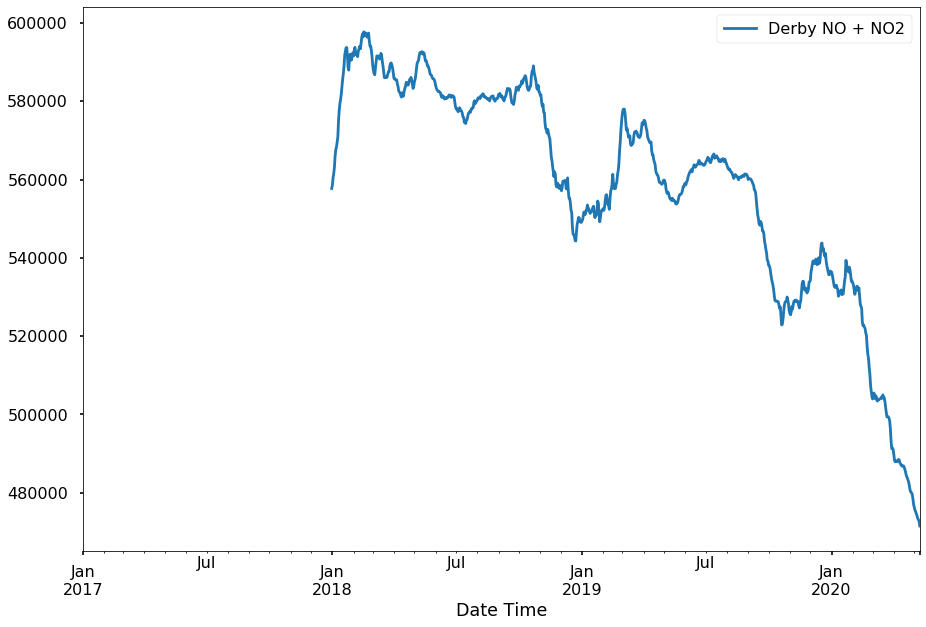

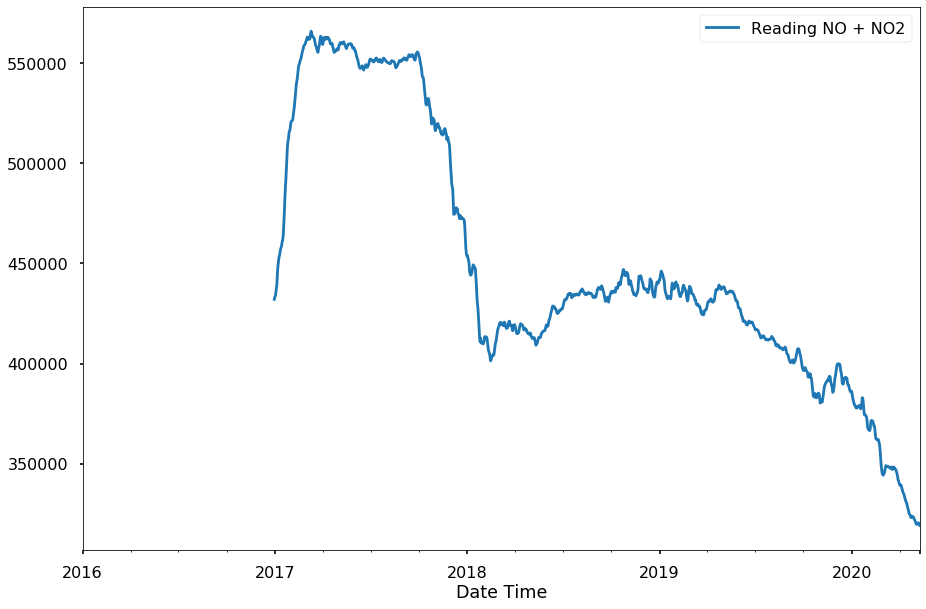

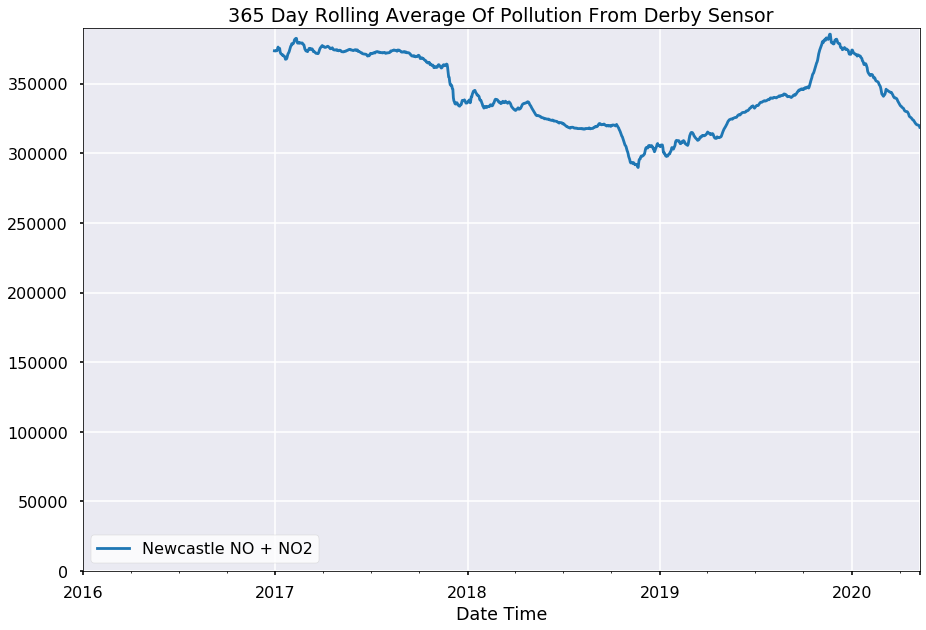

In [139]:
# Matplotlib plot
plt.style.use('seaborn-poster') # making the font bigger so it can be read on Instagram

# Make fig
# Make fig
fig = derby[['Derby NO + NO2']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])
fig = reading[['Reading NO + NO2']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])
fig = newcastle[['Newcastle NO + NO2']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])


# Stylings
fig.set_ylim(0,None)
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('365 Day Rolling Average Of Pollution From Derby Sensor')
plt.legend()
#sns.axes_style({'axes.facecolour':'grey', 'axes.grid':True})